# Skin Cancer MNIST: HAM10000--Using Resnet 50 

In [15]:
# Import Default Packages

import os
import shutil

import cv2
import gc
import keras
import numpy as np
import pandas as pd
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout, Flatten)
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50



# Data Exploration

First check what columns are in the metadata.

In [16]:
metadata = pd.read_csv("/kaggle/input/HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [17]:
# check the proportion of each label
metadata["dx"].value_counts() / metadata.shape[0]

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

In [18]:
image_sample = cv2.imread("/kaggle/input/ham10000_images_part_1/ISIC_0027269.jpg")
print(image_sample.shape)

(450, 600, 3)


In [19]:
lesion_id_cnt = metadata["lesion_id"].value_counts()
def check_duplicates(id):
    
    if lesion_id_cnt[id] > 1:
        return True
    else:
        return False

Images are stored in 2 different folders - part_1 & part_2

Thus, we need to mark which folder each specific image is in.

In [20]:
image_folder_1 = "/kaggle/input/ham10000_images_part_1"
image_folder_2 = "/kaggle/input/ham10000_images_part_2"
metadata["folder"] = 0
metadata.set_index("image_id", drop=False, inplace=True)

for image in os.listdir(image_folder_1):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "1"

for image in os.listdir(image_folder_2):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "2"

In [21]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

metadata['cell_type'] = metadata['dx'].map(lesion_type_dict.get) 
metadata['cell_type_idx'] = pd.Categorical(metadata['cell_type']).codes

In [22]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,folder,cell_type,cell_type_idx
image_id,,,,,,,,,,
ISIC_0027419,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,1,Benign keratosis-like lesions,2
ISIC_0025030,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,1,Benign keratosis-like lesions,2
ISIC_0026769,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,1,Benign keratosis-like lesions,2
ISIC_0025661,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,1,Benign keratosis-like lesions,2
ISIC_0031633,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,Benign keratosis-like lesions,2


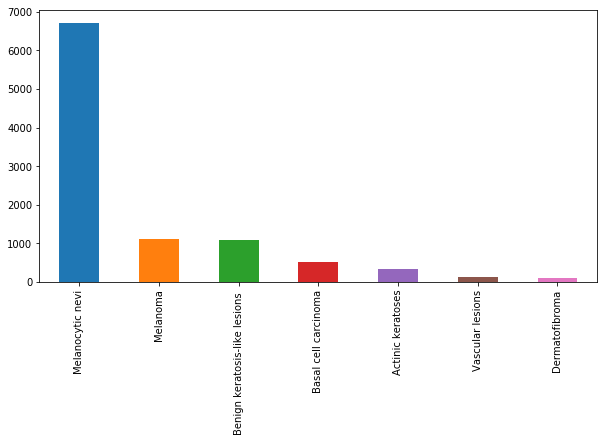

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
metadata['cell_type'].value_counts().plot(kind='bar', ax=ax1)

As it can be seen, the data is highly imbalanced. Thus data pre-processing is required.

# Data Pre-processing

Undersampling nv class

In [24]:
df_nv = metadata[metadata['dx'] == 'nv']
df_not_nv = metadata[metadata['dx'] != 'nv']

In [25]:
from sklearn.utils import shuffle

df_nv = shuffle(df_nv)

In [26]:
df_nv.count()

lesion_id        6705
image_id         6705
dx               6705
dx_type          6705
age              6660
sex              6705
localization     6705
folder           6705
cell_type        6705
cell_type_idx    6705
dtype: int64

In [27]:
df_nv = df_nv.head(1250)

In [28]:
df_nv = df_nv.reset_index(drop = True)

In [29]:
dataset_final = pd.concat([df_nv, df_not_nv])

In [30]:
dataset_final.shape

(4560, 10)

In [31]:
dataset_final['cell_type'].value_counts()

Melanocytic nevi                  1250
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [32]:
dataset_final.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,folder,cell_type,cell_type_idx
0,HAM_0003908,ISIC_0030854,nv,follow_up,30.0,male,trunk,2,Melanocytic nevi,4
1,HAM_0006185,ISIC_0032309,nv,histo,25.0,male,trunk,2,Melanocytic nevi,4
2,HAM_0005154,ISIC_0030977,nv,consensus,55.0,male,back,2,Melanocytic nevi,4
3,HAM_0001007,ISIC_0031758,nv,follow_up,40.0,female,lower extremity,2,Melanocytic nevi,4
4,HAM_0005107,ISIC_0026502,nv,histo,55.0,female,back,1,Melanocytic nevi,4


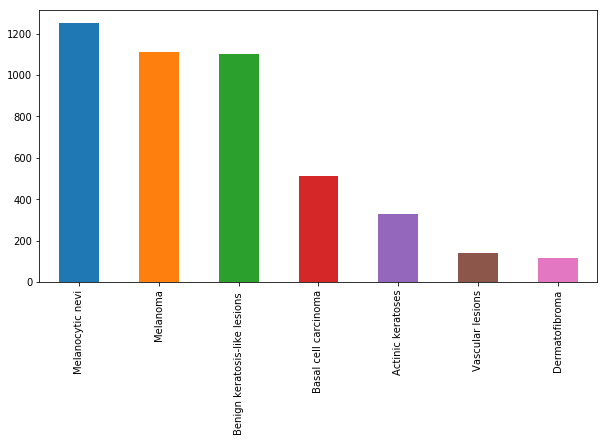

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
dataset_final['cell_type'].value_counts().plot(kind='bar', ax=ax1)

undersampling technique is used to decrease the amount of the majority class, nv. 

# Split the Data into train / validation / test set 

Now I need to split the data into training/validation/test datasets. I split the data in a 80%-10%-10% fashion.

In [34]:
X=dataset_final.drop(columns=['cell_type_idx'],axis=1)
Y_cat=dataset_final['cell_type_idx']

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

In [36]:
print("Train: " + str(x_train.shape[0] / dataset_final.shape[0]))
print("Test: " + str(x_test.shape[0] / dataset_final.shape[0]))

print("Train: " + str(y_train.shape[0] / dataset_final.shape[0]))
print("Test: " + str(y_test.shape[0] / dataset_final.shape[0]))

Train: 0.8
Test: 0.2
Train: 0.8
Test: 0.2


In [37]:
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [38]:
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size = 0.5, random_state = 2)

In [39]:
print("x Train: " + str(x_train.shape[0] / dataset_final.shape[0]))
print("x Test: " + str(x_test.shape[0] / dataset_final.shape[0]))
print("x Test: " + str(x_validate.shape[0] / dataset_final.shape[0]))

print("y Train: " + str(y_train.shape[0] / dataset_final.shape[0]))
print("y Test: " + str(y_test.shape[0] / dataset_final.shape[0]))
print("y Test: " + str(y_validate.shape[0] / dataset_final.shape[0]))

x Train: 0.8
x Test: 0.1
x Test: 0.1
y Train: 0.8
y Test: 0.1
y Test: 0.1


In [40]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [41]:
base_dir = "base_dir"
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, "image_train")
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, "image_val")
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, "image_test")
os.mkdir(test_dir)

In [42]:
labels = list(metadata["dx"].unique())

for label in labels:
    label_path_train = os.path.join(train_dir, label)
    os.mkdir(label_path_train)
    label_path_val = os.path.join(val_dir, label)
    os.mkdir(label_path_val)
    label_path_test = os.path.join(test_dir, label)
    os.mkdir(label_path_test)

Copy the images to the new directory.

In [43]:
image_dir = "/kaggle/input/ham10000_images_part_"


for i in range(x_train.shape[0]):
    image_name = x_train["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + x_train["folder"][i], image_name)
    dst_dir = os.path.join(train_dir, x_train["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

for i in range(x_validate.shape[0]):
    image_name = x_validate["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + x_validate["folder"][i], image_name)
    dst_dir = os.path.join(val_dir, x_validate["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)
    
for i in range(x_test.shape[0]):
    image_name = x_test["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + x_test["folder"][i], image_name)
    dst_dir = os.path.join(test_dir, x_test["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

In [44]:
# check the amount of each label in each dataset before data augmentation
for label in labels:
    print(label + " train: " + str(len(os.listdir(os.path.join(train_dir, label)))))
print("\n")
for label in labels:
    print(label + " val: " + str(len(os.listdir(os.path.join(val_dir, label)))))
print("\n")
for label in labels:
    print(label + " test: " + str(len(os.listdir(os.path.join(test_dir, label)))))

bkl train: 654
nv train: 972
df train: 70
mel train: 671
vasc train: 67
bcc train: 310
akiec train: 183


bkl val: 104
nv val: 118
df val: 8
mel val: 108
vasc val: 12
bcc val: 37
akiec val: 29


bkl test: 73
nv test: 140
df test: 12
mel test: 94
vasc test: 15
bcc test: 45
akiec test: 32


In [45]:
# Delete the redundant data and collect the RAM.
del x_train, metadata
gc.collect()

34

# Data Agumentation

In [46]:
data_gen_param = {
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True
}
data_generator = ImageDataGenerator(**data_gen_param)
num_images_each_label = 1000

aug_dir = os.path.join(base_dir, "aug_dir")
os.mkdir(aug_dir)

for label in labels:
    
    img_dir = os.path.join(aug_dir, "aug_img")
    os.mkdir(img_dir)
    
    src_dir_label = os.path.join(train_dir, label)
    for image_name in os.listdir(src_dir_label):
        shutil.copy(os.path.join(src_dir_label, image_name), os.path.join(img_dir, image_name))
    
    batch_size = 35
    data_flow_param = {
        "directory": aug_dir,
        "color_mode": "rgb",
        "batch_size": batch_size,
        "shuffle": True,
        "save_to_dir": os.path.join(train_dir, label),
        "save_format": "jpg"
    }
    aug_data_gen = data_generator.flow_from_directory(**data_flow_param)
    
    num_img_aug = num_images_each_label - len(os.listdir(os.path.join(train_dir, label)))
    num_batch = int(num_img_aug / batch_size)
    
    for i in range(0, num_batch):
        next(aug_data_gen)
    
    shutil.rmtree(img_dir)

Found 654 images belonging to 1 classes.
Found 972 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
Found 671 images belonging to 1 classes.
Found 67 images belonging to 1 classes.
Found 310 images belonging to 1 classes.
Found 183 images belonging to 1 classes.


Now check if the data is balanced.

In [47]:
for label in labels:
    print(label + " train: " + str(len(os.listdir(os.path.join(train_dir, label)))))
print("\n")
for label in labels:
    print(label + " val: " + str(len(os.listdir(os.path.join(val_dir, label)))))

bkl train: 969
nv train: 972
df train: 980
mel train: 986
vasc train: 938
bcc train: 965
akiec train: 907


bkl val: 104
nv val: 118
df val: 8
mel val: 108
vasc val: 12
bcc val: 37
akiec val: 29


In [48]:
# after data augmentation, the training data for each label are around 1,000  
for label in labels:
    print(label + " train: " + str(len(os.listdir(os.path.join(train_dir, label)))))

bkl train: 969
nv train: 972
df train: 980
mel train: 986
vasc train: 938
bcc train: 965
akiec train: 907


# Define Model

In [49]:
# three models are defined 
# model_64 : 64 * 64 * 3      -> model_low_resolution
# model_128 : 128 * 128 * 3   -> model_mid_resolution
# model_256 : 256 * 256 * 3   -> model_high_resolution

model_64 = ResNet50(include_top=True, weights=None, input_shape=(64, 64, 3), pooling=max, classes=7)
model_128 = ResNet50(include_top=True, weights=None, input_shape=(128, 128, 3), pooling=max, classes=7)
model_256 = ResNet50(include_top=True, weights=None, input_shape=(256, 256, 3), pooling=max, classes=7)

In [50]:
model_low_resolution = Sequential()
model_low_resolution.add(model_64)


model_mid_resolution = Sequential()
model_mid_resolution.add(model_128)

model_high_resolution = Sequential()
model_high_resolution.add(model_256)


In [51]:
model_low_resolution.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
model_mid_resolution.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])
model_high_resolution.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

# Training

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test, test_size = 0.5, random_state = 2)

In [53]:
# checkpoint

filepath = "model.h5"

checkpoint_param = {
    "filepath": filepath,
    "monitor": "val_categorical_accuracy",
    "verbose": 1,
    "save_best_only": True,
    "mode": "max"
}
checkpoint = ModelCheckpoint(**checkpoint_param)

lr_decay_params = {
    "monitor": "val_loss",
    "factor": 0.5,
    "patience": 2,
    "min_lr": 1e-5
}
lr_decay = ReduceLROnPlateau(**lr_decay_params)

early_stopping = EarlyStopping(monitor="val_loss", patience=4, verbose=1)

# Training > model_low_resolution

In [54]:
# generator 

IMAGE_SHAPE = (64, 64, 3)
data_gen_param = {
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": 1.0 / 255
}
data_generator = ImageDataGenerator(**data_gen_param)

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": True
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 6717 images belonging to 7 classes.
Found 416 images belonging to 7 classes.
Found 411 images belonging to 7 classes.


In [55]:
fit_params = {
    "generator": train_flow,
    "steps_per_epoch": x_train.shape[0] // batch_size,
    "epochs": 20,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": x_validate.shape[0] // batch_size,
    "callbacks": [checkpoint, lr_decay, early_stopping]
}
print("Training the model...")

history_low = model_low_resolution.fit_generator(**fit_params)
print("Done!")

Training the model...
Epoch 1/20
104/104 [==============================] - 54s 523ms/step - loss: 2.1736 - acc: 0.3129 - val_loss: 183.2197 - val_acc: 0.0310
Epoch 2/20
104/104 [==============================] - 31s 295ms/step - loss: 1.4525 - acc: 0.4259 - val_loss: 2.0768 - val_acc: 0.2639
Epoch 3/20
104/104 [==============================] - 30s 289ms/step - loss: 1.9233 - acc: 0.4008 - val_loss: 412.7292 - val_acc: 0.0266
Epoch 4/20
104/104 [==============================] - 33s 316ms/step - loss: 1.5043 - acc: 0.4495 - val_loss: 7.2554 - val_acc: 0.3016
Epoch 5/20
104/104 [==============================] - 30s 293ms/step - loss: 1.2662 - acc: 0.5122 - val_loss: 1.2291 - val_acc: 0.5078
Epoch 6/20
104/104 [==============================] - 30s 288ms/step - loss: 1.2851 - acc: 0.5352 - val_loss: 10.9517 - val_acc: 0.2062
Epoch 7/20
104/104 [==============================] - 31s 297ms/step - loss: 1.2662 - acc: 0.5103 - val_loss: 1.2837 - val_acc: 0.4678
Epoch 8/20
104/104 [========

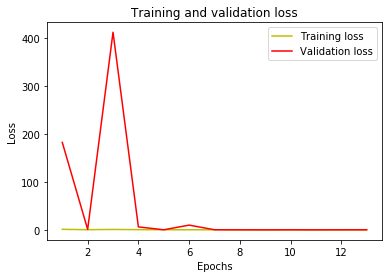

In [56]:
loss = history_low.history['loss']
val_loss = history_low.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

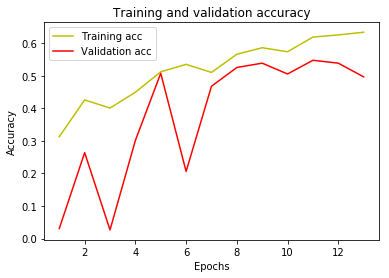

In [57]:
acc = history_low.history['acc']
val_acc = history_low.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation > model_low_resolution

See the accuracies and F1 scores on validation and test sets.

In [58]:
_, val_acc = model_low_resolution.evaluate_generator(val_flow, steps=len(val_flow))
y_val_true = val_flow.classes
y_val_pred = np.argmax(model_low_resolution.predict_generator(val_flow, steps=len(val_flow)), axis=1)
val_f1_score = f1_score(y_val_true, y_val_pred, average="micro")

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation F1 score: {:.4f}".format(val_f1_score))

Validation accuracy: 0.4808
Validation F1 score: 0.4760


In [59]:
_, test_acc = model_low_resolution.evaluate_generator(test_flow, steps=len(test_flow))
y_test_true = test_flow.classes
y_test_pred = np.argmax(model_low_resolution.predict_generator(test_flow, steps=len(test_flow)), axis=1)
test_f1_score = f1_score(y_test_true, y_test_pred, average="micro")

print("Test accuracy: {:.4f}".format(test_acc))
print("Test F1 score: {:.4f}".format(test_f1_score))

Test accuracy: 0.4818
Test F1 score: 0.4915


Track the performance on each epoch.

In [60]:
loss_train = history_low.history["loss"]
acc_train = history_low.history["acc"]
loss_val = history_low.history["val_loss"]
acc_val = history_low.history["val_acc"]
epochs = np.arange(1, len(loss_train) + 1)

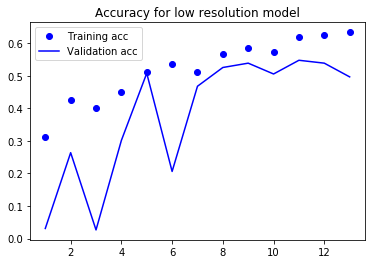

In [61]:
plt.plot(epochs, acc_train, "bo", label="Training acc")
plt.plot(epochs, acc_val, "b", label="Validation acc")
plt.title("Accuracy for low resolution model")
plt.legend()
plt.show()

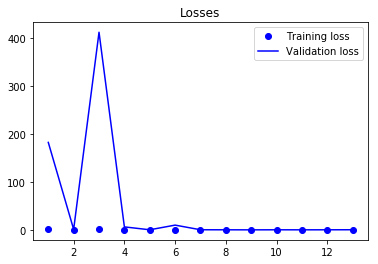

In [62]:
plt.plot(epochs, loss_train, "bo", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Losses")
plt.legend()
plt.show()

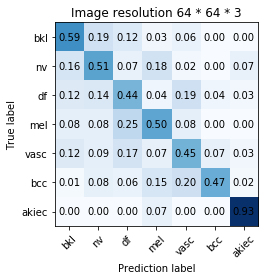

In [63]:
conf_mat = confusion_matrix(y_test_true, y_test_pred)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Image resolution 64 * 64 * 3")
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel("True label")
plt.xlabel("Prediction label")

fmt = '.2f'
thresh = 1
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 ha="center", va="center", color="white" if conf_mat[i, j] > thresh else "black")  #horizontalalignment
        
plt.tight_layout()

Delete the image folder so that it won't output that many files when committed.

# ROC > model_low_resolution

In [64]:
predictions = model_low_resolution.predict_generator(test_flow, steps=len(x_validate), verbose=1)

456/456 [==============================] - 9s 19ms/step


In [65]:
predictions.shape

(456, 7)

In [66]:
test_flow.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [67]:
test_labels = test_flow.classes

In [68]:
test_labels.shape

(411,)

In [69]:
lable_onehot = np.zeros([len(x_validate),7],dtype=np.int)
for i in range(len(test_labels)):
    for t in range(7):
        if(test_labels[i]==t):
            lable_onehot[i][t] = 1
        else:
            lable_onehot[i][t] = 0

scores_val = predictions

In [70]:
lable_onehot

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

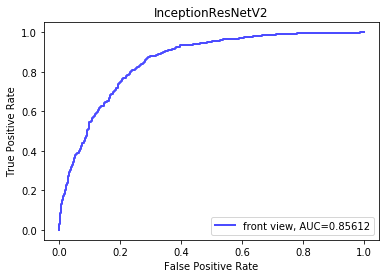

In [71]:
import sklearn
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(lable_onehot.ravel(),scores_val.ravel())
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, c = 'b', lw = 2, alpha = 0.7, label = u'front view, AUC=%.5f' % auc)
plt.title('InceptionResNetV2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

In [72]:
#Compute ROC curve for each classes 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = metrics.roc_curve(lable_onehot[:, i], scores_val[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    
# Compute micro-average ROC curve and ROC area 
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(lable_onehot.ravel(), scores_val.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [73]:
roc_auc

{0: 0.8613649764150942,
 1: 0.8514733711814004,
 2: 0.778854751600558,
 3: 0.75,
 4: 0.8437757141177853,
 5: 0.873869801084991,
 6: 0.9789871504157218,
 'micro': 0.8561161024015062}

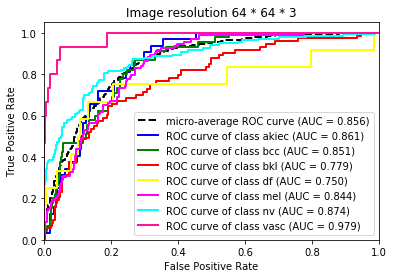

In [74]:
# Plot all ROC curves
import itertools

lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='black', linestyle='--', linewidth=2)

colors = itertools.cycle(['blue', 'green', 'red','yellow', 'magenta', 'cyan','deeppink'])
class_labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel',5:'nv', 6:'vasc'}
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(class_labels[i], roc_auc[i]))

#ROC curves of InceptionResNetV2 for each classes and micro-average
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Image resolution 64 * 64 * 3')
plt.legend(loc="lower right")
plt.show()

--------------------------------------
# Training > model_mid_resolution

In [75]:
# generator 

IMAGE_SHAPE = (128, 128, 3)
data_gen_param = {
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": 1.0 / 255
}
data_generator = ImageDataGenerator(**data_gen_param)

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": True
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 6717 images belonging to 7 classes.
Found 416 images belonging to 7 classes.
Found 411 images belonging to 7 classes.


In [76]:
fit_params = {
    "generator": train_flow,
    "steps_per_epoch": x_train.shape[0] // batch_size,
    "epochs": 20,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": x_validate.shape[0] // batch_size,
    "callbacks": [checkpoint, lr_decay, early_stopping]
}
print("Training the model...")

history_mid = model_mid_resolution.fit_generator(**fit_params)
print("Done!")

Training the model...
Epoch 1/20
104/104 [==============================] - 66s 633ms/step - loss: 1.8781 - acc: 0.3698 - val_loss: 2363.2045 - val_acc: 0.0266
Epoch 2/20
104/104 [==============================] - 42s 402ms/step - loss: 1.5530 - acc: 0.4225 - val_loss: 13.1222 - val_acc: 0.1486
Epoch 3/20
104/104 [==============================] - 42s 402ms/step - loss: 1.5346 - acc: 0.4358 - val_loss: 333.4126 - val_acc: 0.0931
Epoch 4/20
104/104 [==============================] - 42s 402ms/step - loss: 1.4043 - acc: 0.4688 - val_loss: 1.6617 - val_acc: 0.4146
Epoch 5/20
104/104 [==============================] - 42s 407ms/step - loss: 1.2969 - acc: 0.4959 - val_loss: 1.3127 - val_acc: 0.4634
Epoch 6/20
104/104 [==============================] - 42s 402ms/step - loss: 1.2999 - acc: 0.5045 - val_loss: 1.3174 - val_acc: 0.4435
Epoch 7/20
104/104 [==============================] - 45s 433ms/step - loss: 1.2910 - acc: 0.5214 - val_loss: 1.8162 - val_acc: 0.2727
Epoch 8/20
104/104 [=======

# Evaluation > model_mid_resolution

In [77]:
_, val_acc = model_mid_resolution.evaluate_generator(val_flow, steps=len(val_flow))
y_val_true = val_flow.classes
y_val_pred = np.argmax(model_mid_resolution.predict_generator(val_flow, steps=len(val_flow)), axis=1)
val_f1_score = f1_score(y_val_true, y_val_pred, average="micro")

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation F1 score: {:.4f}".format(val_f1_score))

Validation accuracy: 0.5938
Validation F1 score: 0.5938


In [78]:
_, test_acc = model_mid_resolution.evaluate_generator(test_flow, steps=len(test_flow))
y_test_true = test_flow.classes
y_test_pred = np.argmax(model_mid_resolution.predict_generator(test_flow, steps=len(test_flow)), axis=1)
test_f1_score = f1_score(y_test_true, y_test_pred, average="micro")

print("Test accuracy: {:.4f}".format(test_acc))
print("Test F1 score: {:.4f}".format(test_f1_score))

Test accuracy: 0.6156
Test F1 score: 0.6131


In [79]:
loss_train = history_mid.history["loss"]
acc_train = history_mid.history["acc"]
loss_val = history_mid.history["val_loss"]
acc_val = history_mid.history["val_acc"]
epochs = np.arange(1, len(loss_train) + 1)

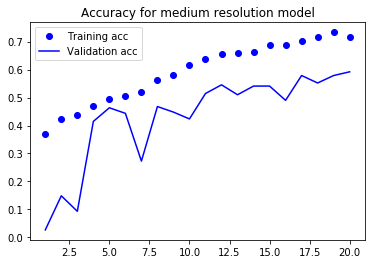

In [80]:
plt.plot(epochs, acc_train, "bo", label="Training acc")
plt.plot(epochs, acc_val, "b", label="Validation acc")
plt.title("Accuracy for medium resolution model")
plt.legend()
plt.show()

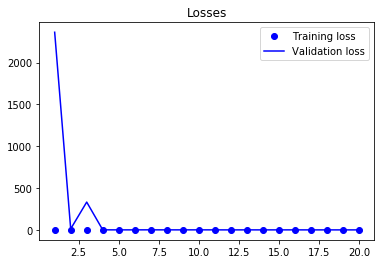

In [81]:
plt.plot(epochs, loss_train, "bo", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Losses")
plt.legend()
plt.show()

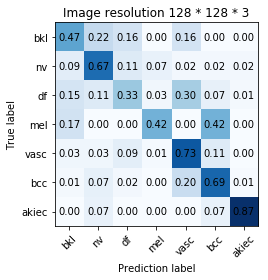

In [82]:
conf_mat = confusion_matrix(y_test_true, y_test_pred)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Image resolution 128 * 128 * 3")
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel("True label")
plt.xlabel("Prediction label")

fmt = '.2f'
thresh = 1
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 ha="center", va="center", color="white" if conf_mat[i, j] > thresh else "black")  #horizontalalignment
        
plt.tight_layout()

# ROC > model_mid_resolution

In [83]:
predictions = model_mid_resolution.predict_generator(test_flow, steps=len(x_validate), verbose=1)

456/456 [==============================] - 10s 22ms/step


In [84]:
lable_onehot = np.zeros([len(x_validate),7],dtype=np.int)
for i in range(len(test_labels)):
    for t in range(7):
        if(test_labels[i]==t):
            lable_onehot[i][t] = 1
        else:
            lable_onehot[i][t] = 0
# print(lable_onehot)

scores_val = predictions

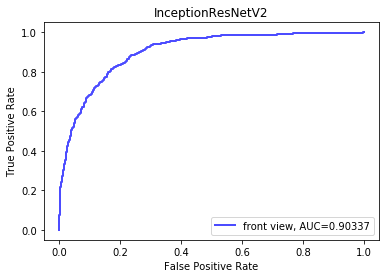

In [85]:
import sklearn
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(lable_onehot.ravel(),scores_val.ravel())
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, c = 'b', lw = 2, alpha = 0.7, label = u'front view, AUC=%.5f' % auc)
plt.title('InceptionResNetV2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

In [86]:
#Compute ROC curve for each classes 
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = metrics.roc_curve(lable_onehot[:, i], scores_val[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(lable_onehot.ravel(), scores_val.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [87]:
roc_auc

{0: 0.8912146226415095,
 1: 0.9145174371451743,
 2: 0.7851496834650739,
 3: 0.8102477477477477,
 4: 0.874485717644293,
 5: 0.8973327305605786,
 6: 0.9165532879818595,
 'micro': 0.9033745672538104}

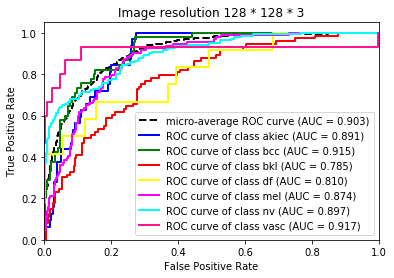

In [88]:
# Plot all ROC curves
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='black', linestyle='--', linewidth=2)

colors = itertools.cycle(['blue', 'green', 'red','yellow', 'magenta', 'cyan','deeppink'])
class_labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel',5:'nv', 6:'vasc'}
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Image resolution 128 * 128 * 3')
plt.legend(loc="lower right")
plt.show()

-------------------------------------------------
# Training > model_high_resolution

In [89]:
IMAGE_SHAPE = (256, 256, 3)
data_gen_param = {
    "samplewise_center": True,
    "samplewise_std_normalization": True,
    "rotation_range": 180,
    "width_shift_range": 0.1,
    "height_shift_range": 0.1,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "vertical_flip": True,
    "rescale": 1.0 / 255
}
data_generator = ImageDataGenerator(**data_gen_param)

train_flow_param = {
    "directory": train_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": True
}
train_flow = data_generator.flow_from_directory(**train_flow_param)

val_flow_param = {
    "directory": val_dir,
    "batch_size": batch_size,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
val_flow = data_generator.flow_from_directory(**val_flow_param)

test_flow_param = {
    "directory": test_dir,
    "batch_size": 1,
    "target_size": IMAGE_SHAPE[:2],
    "shuffle": False
}
test_flow = data_generator.flow_from_directory(**test_flow_param)

Found 6717 images belonging to 7 classes.
Found 416 images belonging to 7 classes.
Found 411 images belonging to 7 classes.


In [90]:
fit_params = {
    "generator": train_flow,
    "steps_per_epoch": x_train.shape[0] // batch_size,
    "epochs": 20,
    "verbose": 1,
    "validation_data": val_flow,
    "validation_steps": x_validate.shape[0] // batch_size,
    "callbacks": [checkpoint, lr_decay, early_stopping]
}
print("Training the model...")

history_high = model_high_resolution.fit_generator(**fit_params)
print("Done!")

Training the model...
Epoch 1/20
104/104 [==============================] - 116s 1s/step - loss: 1.7931 - acc: 0.3621 - val_loss: 49.5586 - val_acc: 0.0288
Epoch 2/20
104/104 [==============================] - 88s 849ms/step - loss: 1.4377 - acc: 0.4490 - val_loss: 6.6046 - val_acc: 0.0510
Epoch 3/20
104/104 [==============================] - 88s 848ms/step - loss: 1.4579 - acc: 0.4548 - val_loss: 2.4731 - val_acc: 0.1729
Epoch 4/20
104/104 [==============================] - 88s 846ms/step - loss: 1.3279 - acc: 0.5029 - val_loss: 8.9747 - val_acc: 0.0976
Epoch 5/20
104/104 [==============================] - 89s 854ms/step - loss: 1.2140 - acc: 0.5168 - val_loss: 2.1929 - val_acc: 0.2772
Epoch 6/20
104/104 [==============================] - 89s 854ms/step - loss: 1.2126 - acc: 0.5354 - val_loss: 1.6116 - val_acc: 0.4169
Epoch 7/20
104/104 [==============================] - 88s 844ms/step - loss: 1.1776 - acc: 0.5450 - val_loss: 2.2167 - val_acc: 0.2683
Epoch 8/20
104/104 [==============

# Evaluation > model_high_resolution

In [91]:
_, val_acc = model_high_resolution.evaluate_generator(val_flow, steps=len(val_flow))
y_val_true = val_flow.classes
y_val_pred = np.argmax(model_high_resolution.predict_generator(val_flow, steps=len(val_flow)), axis=1)
val_f1_score = f1_score(y_val_true, y_val_pred, average="micro")

print("Validation accuracy: {:.4f}".format(val_acc))
print("Validation F1 score: {:.4f}".format(val_f1_score))

Validation accuracy: 0.5817
Validation F1 score: 0.6106


In [92]:
_, test_acc = model_high_resolution.evaluate_generator(test_flow, steps=len(test_flow))
y_test_true = test_flow.classes
y_test_pred = np.argmax(model_high_resolution.predict_generator(test_flow, steps=len(test_flow)), axis=1)
test_f1_score = f1_score(y_test_true, y_test_pred, average="micro")

print("Test accuracy: {:.4f}".format(test_acc))
print("Test F1 score: {:.4f}".format(test_f1_score))

Test accuracy: 0.5985
Test F1 score: 0.6083


In [93]:
loss_train = history_high.history["loss"]
acc_train = history_high.history["acc"]
loss_val = history_high.history["val_loss"]
acc_val = history_high.history["val_acc"]
epochs = np.arange(1, len(loss_train) + 1)

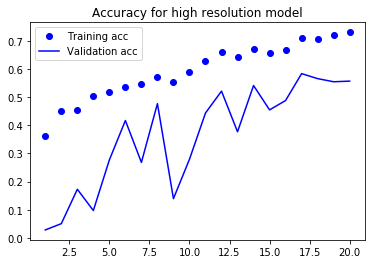

In [94]:
plt.plot(epochs, acc_train, "bo", label="Training acc")
plt.plot(epochs, acc_val, "b", label="Validation acc")
plt.title("Accuracy for high resolution model")
plt.legend()
plt.show()

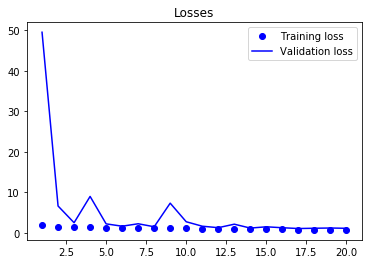

In [95]:
plt.plot(epochs, loss_train, "bo", label="Training loss")
plt.plot(epochs, loss_val, "b", label="Validation loss")
plt.title("Losses")
plt.legend()
plt.show()

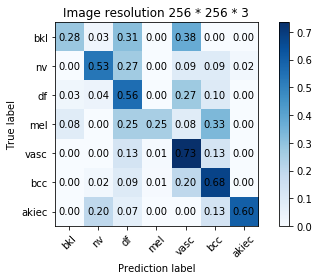

In [96]:
conf_mat = confusion_matrix(y_test_true, y_test_pred)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
plt.imshow(conf_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Image resolution 256 * 256 * 3")
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.ylabel("True label")
plt.xlabel("Prediction label")

fmt = '.2f'
thresh = 1
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 ha="center", va="center", color="white" if conf_mat[i, j] > thresh else "black")  #horizontalalignment
        
plt.tight_layout()

# ROC > model_high_resolution

In [97]:
predictions = model_high_resolution.predict_generator(test_flow, steps=len(x_validate), verbose=1)

456/456 [==============================] - 15s 32ms/step


In [98]:
lable_onehot = np.zeros([len(x_validate),7],dtype=np.int)
for i in range(len(test_labels)):
    for t in range(7):
        if(test_labels[i]==t):
            lable_onehot[i][t] = 1
        else:
            lable_onehot[i][t] = 0
# print(lable_onehot)

scores_val = predictions

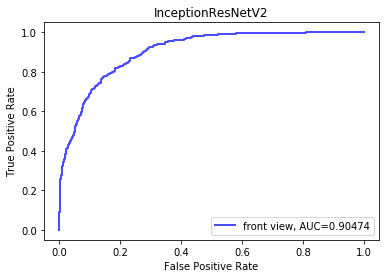

In [99]:
import sklearn
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(lable_onehot.ravel(),scores_val.ravel())
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, c = 'b', lw = 2, alpha = 0.7, label = u'front view, AUC=%.5f' % auc)
plt.title('InceptionResNetV2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

In [100]:
#Compute ROC curve for each classes 画每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = metrics.roc_curve(lable_onehot[:, i], scores_val[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    
# Compute micro-average ROC curve and ROC area 计算宏观平均ROC
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(lable_onehot.ravel(), scores_val.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

In [101]:
roc_auc

{0: 0.8590801886792453,
 1: 0.9240875912408759,
 2: 0.8511749347258486,
 3: 0.8751876876876877,
 4: 0.8342835312095921,
 5: 0.8794529837251357,
 6: 0.9953136810279667,
 'micro': 0.9047394073969086}

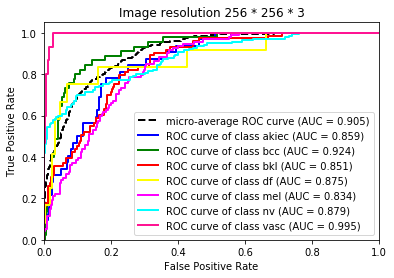

In [102]:
# Plot all ROC curves

import itertools


lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (AUC = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='black', linestyle='--', linewidth=2)

colors = itertools.cycle(['blue', 'green', 'red','yellow', 'magenta', 'cyan','deeppink'])
class_labels = {0:'akiec', 1:'bcc', 2:'bkl', 3:'df', 4:'mel',5:'nv', 6:'vasc'}
# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(7), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Image resolution 256 * 256 * 3')
plt.legend(loc="lower right")
plt.show()